<a href="https://colab.research.google.com/github/rogeralexei/tensorflow-deep-learning/blob/main/Gatos_y_Perros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RNC para predecir si se presenta la imágen de un perro o un gato - Roger Urrutia


Dentro de este notebook (1=perro, 0=gato)

### Agregar Dataset (Almacenado en mi google drive personal)



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importar Modulos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import random
import os
from keras_preprocessing.image import load_img
warnings.filterwarnings("ignore")

### Crear Dataframe

In [3]:
drive_path="./drive/MyDrive/Collab_Drive/dogs_vs_cats/"
input_path=[]
label=[]

for clase in os.listdir(drive_path):
  for path in tqdm(os.listdir(drive_path+clase)):
    if clase=="cats":
      label.append("0")
    else:
      label.append("1")
    input_path.append(os.path.join(drive_path,clase,path))

print(input_path[0],label[0])

100%|██████████| 12500/12500 [00:00<00:00, 147075.67it/s]

./drive/MyDrive/Collab_Drive/dogs_vs_cats/cats/cat.10210.jpg 0


In [4]:
len(label)
len(input_path)

25000

In [5]:
df=pd.DataFrame()
df["imagenes"]= input_path
df["label"]=label
#Mezcla de los datos (shuffle)
df=df.sample(frac=1).reset_index(drop=True)
df.head()

imagenes label
0  ./drive/MyDrive/Collab_Drive/dogs_vs_cats/cats...     0
1  ./drive/MyDrive/Collab_Drive/dogs_vs_cats/dogs...     1
2  ./drive/MyDrive/Collab_Drive/dogs_vs_cats/dogs...     1
3  ./drive/MyDrive/Collab_Drive/dogs_vs_cats/dogs...     1
4  ./drive/MyDrive/Collab_Drive/dogs_vs_cats/cats...     0

In [6]:
#Split
from sklearn.model_selection import train_test_split
train, test= train_test_split(df, test_size=0.2,random_state=42)

### Analisis de Datos

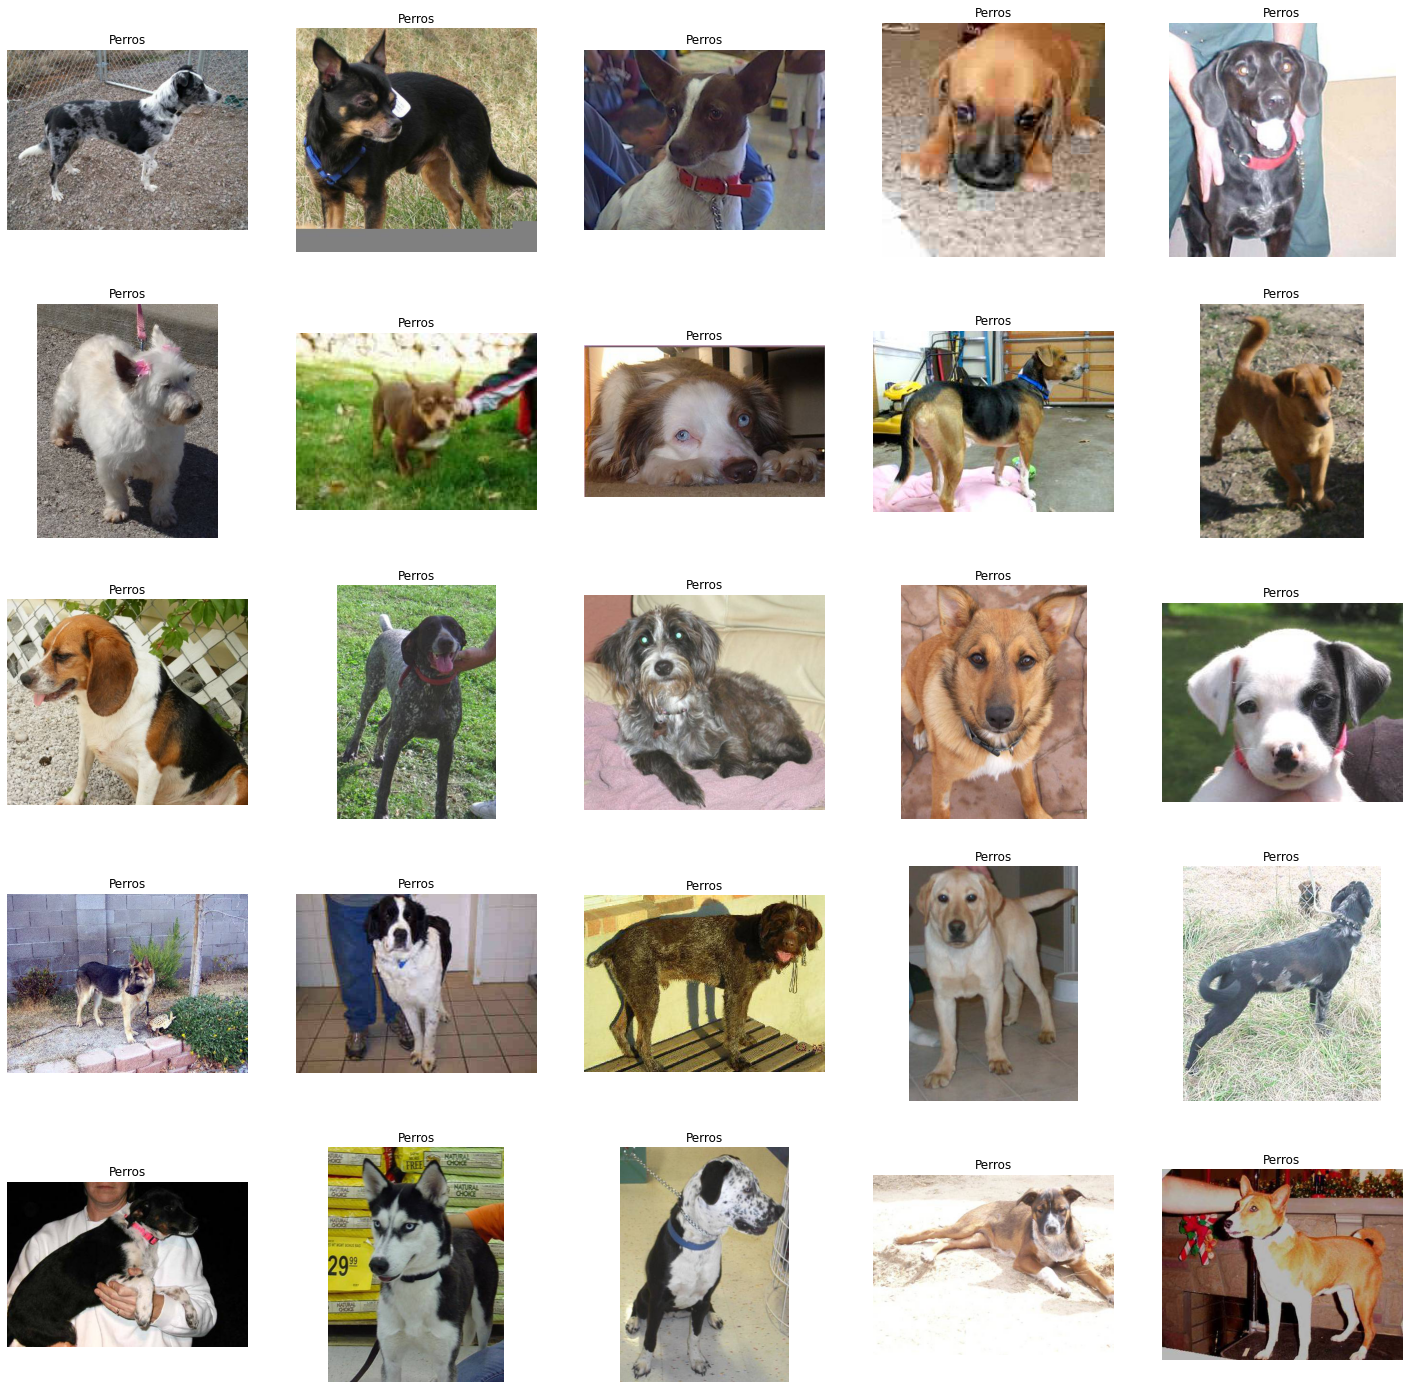

In [7]:
plt.figure(figsize=(25,25))
temp= df[df["label"]=="1"]["imagenes"]
start= random.randint(0,len(temp))
files= temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5,index+1)
  img=load_img(file)
  img=np.array(img)
  plt.imshow(img)
  plt.title("Perros")
  plt.axis("off")

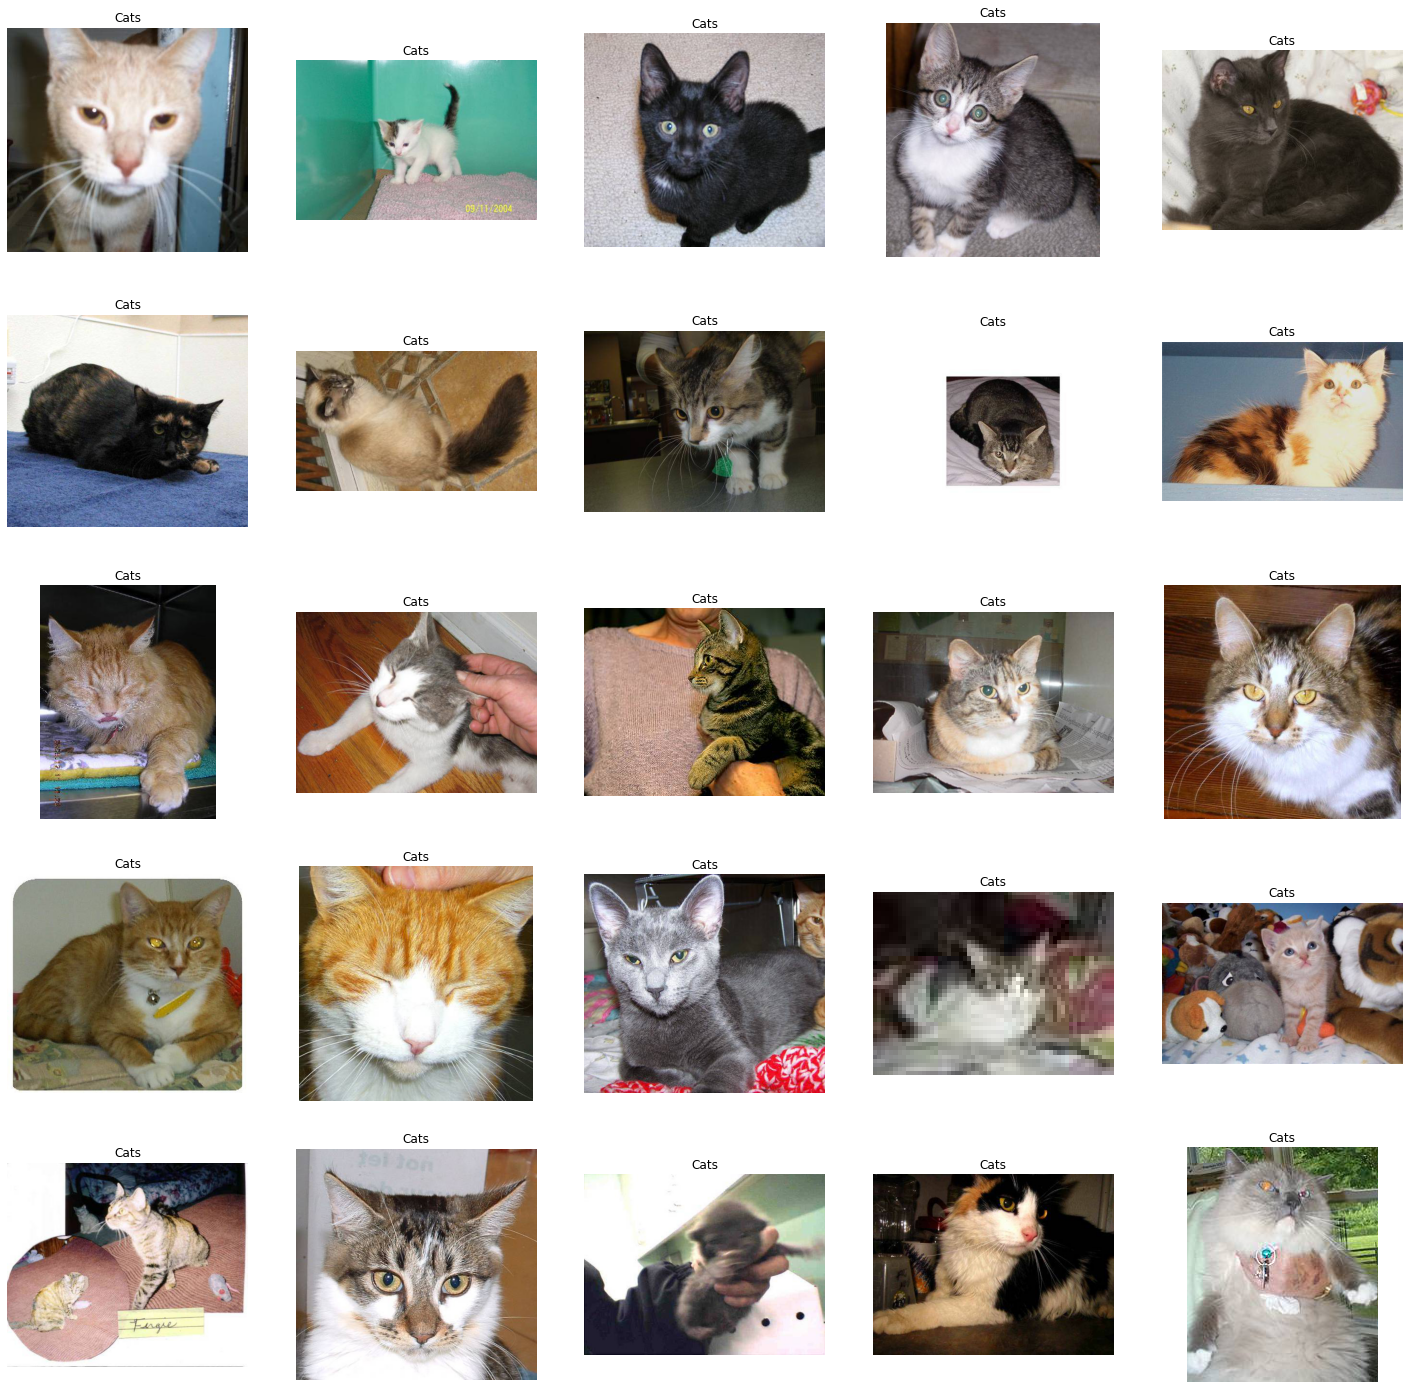

In [8]:
plt.figure(figsize=(25,25))
temp= df[df["label"]=="0"]["imagenes"]
start= random.randint(0,len(temp))
files= temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5,index+1)
  img=load_img(file)
  img=np.array(img)
  plt.imshow(img)
  plt.title("Cats")
  plt.axis("off")

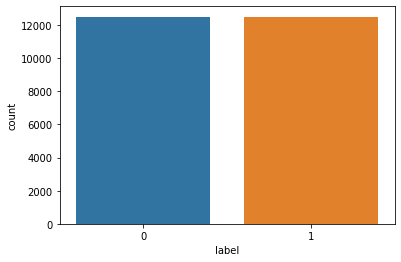

In [9]:
import seaborn as sns
sns.countplot(df["label"])

### DataGenerator para las imagenes


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator=ImageDataGenerator(
    #Normalizacion de las imagenes
    rescale=1./255,
    #Augmentation
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_generator=ImageDataGenerator(
    #Normalizacion de las imagenes
    rescale=1./255,
)

train_iterator= train_generator.flow_from_dataframe(train, x_col="imagenes", y_col="label", target_size=(128,128), batch_size=512, class_mode="binary")

val_iterator= train_generator.flow_from_dataframe(test, x_col="imagenes", y_col="label", target_size=(128,128), batch_size=512, class_mode="binary")

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### Creacion del Modelo

In [11]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model= Sequential([
    Conv2D(16,(3,3), activation="relu", input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Conv2D(32,(3,3), activation="relu"),
    MaxPool2D((2,2)),
    Conv2D(64,(3,3), activation="relu"),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(1,activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [ ]:
history= model.fit(train_iterator, epochs=50, validation_data=val_iterator)

### Visualizacion de resultados

In [ ]:
acc= history.history["accuracy"]
val_acc=  history.history["val_accuracy"]
epochs=range(len(acc))

plt.plot(epochs,"b",acc,label="Precision del Entrenamiento")
plt.plot(epochs,"r",val_acc,label="Precision de la validacion")
plt.title("Grafica de Precision")
plt.legend()
plt.figure()

loss= history.history["loss"]
val_loss=  history.history["val_loss"]

plt.plot(epochs,"b",loss,label="Perdida Entrenamiento")
plt.plot(epochs,"r",val_loss,label="Perdida de la validacion")
plt.title("Grafica de Perdida")
plt.legend()
plt.show()
